In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 필요 library 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

import pickle

In [111]:
# data 경로 설정 
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
data = pd.read_csv(root+"/timeseries_for_classificiation.csv")
data.head()

,Unnamed: 0,time,zone,n_drive,n_drive_unique,month,zone_name,reservation_start_at,reservation_return_at,days,closed,n_unique_car,remaining
0,2231520,2019-08-01 00:00:00,도곡로21길7 공영주차장,1,1,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,1
1,2231521,2019-08-01 01:00:00,도곡로21길7 공영주차장,1,1,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,1
2,2231522,2019-08-01 02:00:00,도곡로21길7 공영주차장,0,0,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,2
3,2231523,2019-08-01 03:00:00,도곡로21길7 공영주차장,0,0,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,2
4,2231524,2019-08-01 04:00:00,도곡로21길7 공영주차장,0,0,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,2


In [112]:
data = data[~data['time'].str.contains("2019-08-31", na=False, case=False)]

In [113]:
# zone name 변환
zone_dictionary = pd.read_csv(root+"/timeseries_zone_dictionary.csv")
zone_dictionary.head()

,unique_id,zone_name
0,0,SK주차장
1,1,용정주차장
2,2,제일주차장
3,3,웨스트엔드 3차
4,4,도곡로21길7 공영주차장


In [256]:
zone_dictionary_ = {}
for i in range(len(zone_dictionary)):
  zone_dictionary_[zone_dictionary['zone_name'][i]] = zone_dictionary['unique_id'][i]

print(zone_dictionary_['SK주차장'],end=' ')
print(zone_dictionary_['용정주차장'],end=' ')
print(zone_dictionary_['제일주차장'],end=' ')

0 1 2 

In [115]:
data.replace({"zone": zone_dictionary_}, inplace=True)
data

,Unnamed: 0,time,zone,n_drive,n_drive_unique,month,zone_name,reservation_start_at,reservation_return_at,days,closed,n_unique_car,remaining
0,2231520,2019-08-01 00:00:00,4,1,1,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,1
1,2231521,2019-08-01 01:00:00,4,1,1,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,1
2,2231522,2019-08-01 02:00:00,4,0,0,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,2
3,2231523,2019-08-01 03:00:00,4,0,0,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,2
4,2231524,2019-08-01 04:00:00,4,0,0,8,도곡로21길7 공영주차장,2018-12-29 19:00:00,2019-11-30 21:46:08,336,False,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188371,854731,2019-03-07 19:00:00,315,1,1,3,한티역 2번출구(메밀연가)(운영종료),2019-01-01 14:00:00,2019-05-07 16:14:53,126,True,2,1
188372,854732,2019-03-07 20:00:00,315,1,1,3,한티역 2번출구(메밀연가)(운영종료),2019-01-01 14:00:00,2019-05-07 16:14:53,126,True,2,1
188373,854733,2019-03-07 21:00:00,315,0,0,3,한티역 2번출구(메밀연가)(운영종료),2019-01-01 14:00:00,2019-05-07 16:14:53,126,True,2,2
188374,854734,2019-03-07 22:00:00,315,0,0,3,한티역 2번출구(메밀연가)(운영종료),2019-01-01 14:00:00,2019-05-07 16:14:53,126,True,2,2


In [116]:
data.columns

Index(['Unnamed: 0', 'time', 'zone', 'n_drive', 'n_drive_unique', 'month',
       'zone_name', 'reservation_start_at', 'reservation_return_at', 'days',
       'closed', 'n_unique_car', 'remaining'],
      dtype='object')

In [117]:
# remaining값이 가장 연관성 크다고 판단
data2 = data.drop(['Unnamed: 0','n_drive','month','n_unique_car',
       'zone_name', 'reservation_start_at', 'reservation_return_at','n_drive_unique'],1)
data2

,time,zone,days,closed,remaining
0,2019-08-01 00:00:00,4,336,False,1
1,2019-08-01 01:00:00,4,336,False,1
2,2019-08-01 02:00:00,4,336,False,2
3,2019-08-01 03:00:00,4,336,False,2
4,2019-08-01 04:00:00,4,336,False,2
...,...,...,...,...,...
188371,2019-03-07 19:00:00,315,126,True,1
188372,2019-03-07 20:00:00,315,126,True,1
188373,2019-03-07 21:00:00,315,126,True,2
188374,2019-03-07 22:00:00,315,126,True,2


In [123]:
# 시계열 데이터 1일 단위로 resampling
data2["time"] = pd.to_datetime(data2["time"])
ts=data2
ts=ts.set_index('time')
ts_resample= pd.DataFrame()
ts_resample['remaining_3H'] = ts.groupby(['zone','days','closed']).remaining.resample('3H').max()
ts_resample.reset_index(inplace = True)
ts_resample = ts_resample[['time','zone','days','closed','remaining_3H']]
ts_resample

,time,zone,days,closed,remaining_3H
0,2019-08-01 00:00:00,4,336,False,2
1,2019-08-01 03:00:00,4,336,False,2
2,2019-08-01 06:00:00,4,336,False,2
3,2019-08-01 09:00:00,4,336,False,1
4,2019-08-01 12:00:00,4,336,False,1
...,...,...,...,...,...
60955,2019-08-30 09:00:00,418,168,False,2
60956,2019-08-30 12:00:00,418,168,False,2
60957,2019-08-30 15:00:00,418,168,False,2
60958,2019-08-30 18:00:00,418,168,False,3


In [263]:
for i in range(240):
  ts_resample[f'lag{i+1}'] = ts_resample.groupby(['zone'])['remaining_3H'].shift(i)
ts_resample[237:245]

,index,time,zone,days,closed,remaining_3H,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,...,lag201,lag202,lag203,lag204,lag205,lag206,lag207,lag208,lag209,lag210,lag211,lag212,lag213,lag214,lag215,lag216,lag217,lag218,lag219,lag220,lag221,lag222,lag223,lag224,lag225,lag226,lag227,lag228,lag229,lag230,lag231,lag232,lag233,lag234,lag235,lag236,lag237,lag238,lag239,lag240
237,237,2019-08-30 15:00:00,4,336,False,2,2,1.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,0.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN,NaN
238,238,2019-08-30 18:00:00,4,336,False,2,2,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN
239,239,2019-08-30 21:00:00,4,336,False,1,1,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,2.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
240,240,2019-08-01 00:00:00,8,332,False,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,241,2019-08-01 03:00:00,8,332,False,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,242,2019-08-01 06:00:00,8,332,False,1,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,243,2019-08-01 09:00:00,8,332,False,1,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,244,2019-08-01 12:00:00,8,332,False,1,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
# 결측값 포함 행 제거
ts_sample = ts_resample.dropna()
ts_sample.tail()

,index,time,zone,days,closed,remaining_3H,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,...,lag201,lag202,lag203,lag204,lag205,lag206,lag207,lag208,lag209,lag210,lag211,lag212,lag213,lag214,lag215,lag216,lag217,lag218,lag219,lag220,lag221,lag222,lag223,lag224,lag225,lag226,lag227,lag228,lag229,lag230,lag231,lag232,lag233,lag234,lag235,lag236,lag237,lag238,lag239,lag240
59999,59999,2019-08-30 21:00:00,414,167,False,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60239,60239,2019-08-30 21:00:00,415,149,False,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60479,60479,2019-08-30 21:00:00,416,111,False,2,2,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
60719,60719,2019-08-30 21:00:00,417,135,False,1,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
60959,60959,2019-08-30 21:00:00,418,168,False,3,3,3.0,2.0,2.0,2.0,3.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0


In [247]:
ts_sample.reset_index(inplace = True)
ts_sample.head()

,level_0,index,time,zone,days,closed,remaining_3H,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,...,lag201,lag202,lag203,lag204,lag205,lag206,lag207,lag208,lag209,lag210,lag211,lag212,lag213,lag214,lag215,lag216,lag217,lag218,lag219,lag220,lag221,lag222,lag223,lag224,lag225,lag226,lag227,lag228,lag229,lag230,lag231,lag232,lag233,lag234,lag235,lag236,lag237,lag238,lag239,lag240
0,239,239,2019-08-30 21:00:00,4,336,False,1,1,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
1,479,479,2019-08-30 21:00:00,8,332,False,1,1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,719,719,2019-08-30 21:00:00,11,333,False,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,959,959,2019-08-30 21:00:00,12,334,False,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1199,1199,2019-08-30 21:00:00,15,333,False,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [248]:
ts_sample = ts_sample.drop(['level_0','time','remaining_3H','index','zone','days'],1)
ts_sample

,closed,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,...,lag201,lag202,lag203,lag204,lag205,lag206,lag207,lag208,lag209,lag210,lag211,lag212,lag213,lag214,lag215,lag216,lag217,lag218,lag219,lag220,lag221,lag222,lag223,lag224,lag225,lag226,lag227,lag228,lag229,lag230,lag231,lag232,lag233,lag234,lag235,lag236,lag237,lag238,lag239,lag240
0,False,1,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
1,False,1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,False,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,False,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
4,False,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,False,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
251,False,2,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
252,False,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [251]:
features = [x for i,x in enumerate(ts_sample.columns) if i != 0]
n_split = round(len(ts_sample)*0.7)
train = ts_sample[:n_split]
test = ts_sample[n_split:]
ts_sample.head()

,closed,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,...,lag201,lag202,lag203,lag204,lag205,lag206,lag207,lag208,lag209,lag210,lag211,lag212,lag213,lag214,lag215,lag216,lag217,lag218,lag219,lag220,lag221,lag222,lag223,lag224,lag225,lag226,lag227,lag228,lag229,lag230,lag231,lag232,lag233,lag234,lag235,lag236,lag237,lag238,lag239,lag240
0,False,1,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
1,False,1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,False,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,False,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
4,False,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [252]:
x_train = np.asarray(train.drop('closed',1))
y_train = np.asarray(train['closed'])
x_test = np.asarray(test.drop('closed',1))
y_test = np.asarray(test['closed'])

In [262]:
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(clf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(x_test, y_test)))

Accuracy on training set: 0.916
Accuracy on test set: 0.855


In [260]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.947


In [261]:
rf1 = RandomForestClassifier(max_features=2, max_depth=3, n_estimators=100, random_state=0)
rf1.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf1.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf1.score(x_test, y_test)))

Accuracy on training set: 0.888
Accuracy on test set: 0.947


In [257]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.882


In [258]:
gb2 = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gb2.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb2.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb2.score(x_test, y_test)))

Accuracy on training set: 0.916
Accuracy on test set: 0.947


In [253]:
from sklearn.ensemble import GradientBoostingClassifier

gb1 = GradientBoostingClassifier(random_state=0, max_depth=2)
gb1.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb1.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb1.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.868


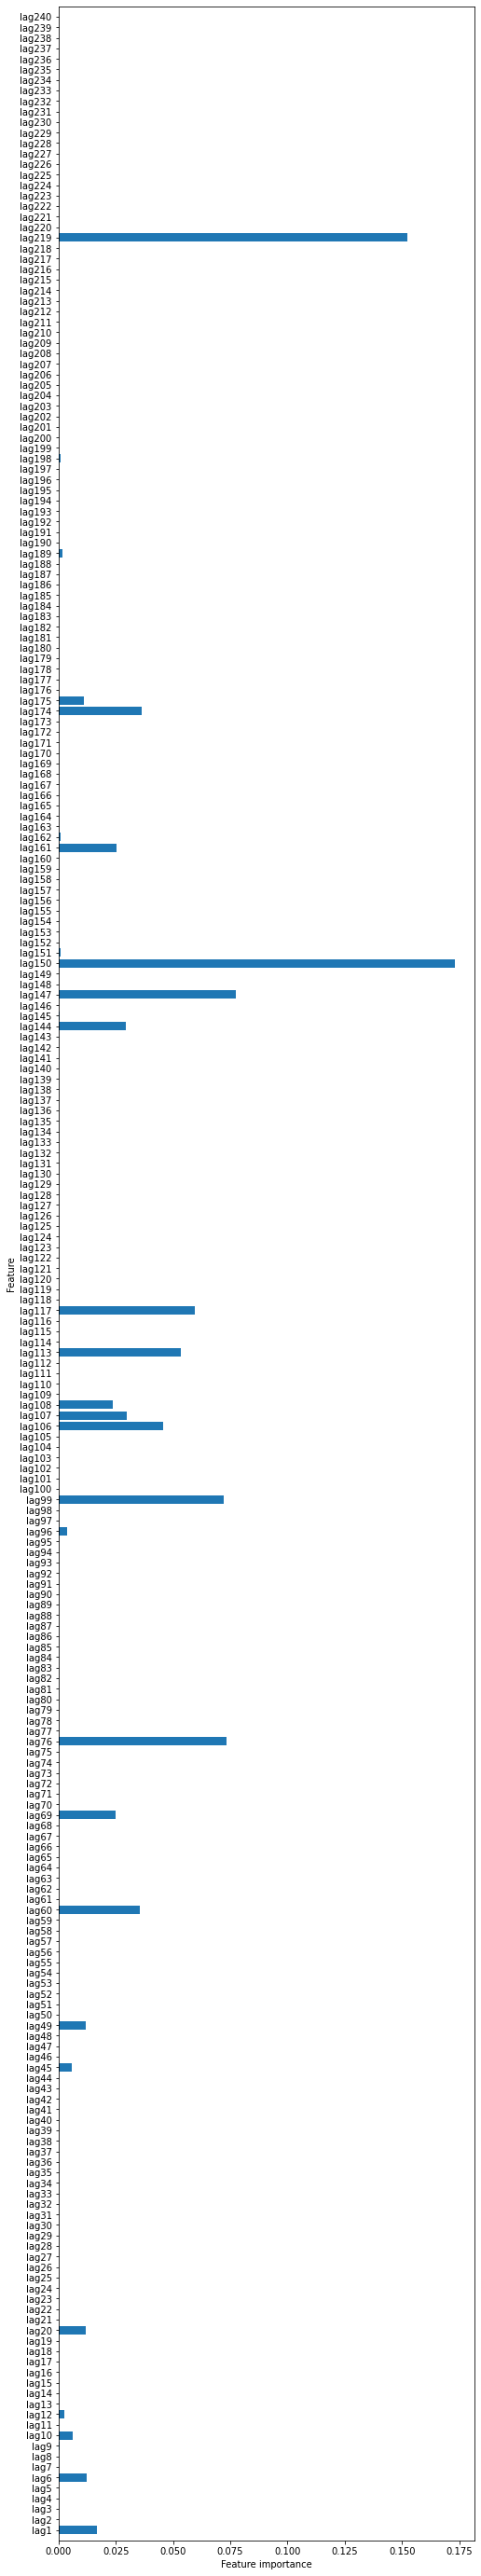

In [259]:
def plot_feature_importances(model):
    plt.figure(figsize=(8,50))
    n_features = 240
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(gb2)